- 기간 : 3월 6일 ~ 31일
- 진행상황
    - 불용어 처리
        - 잘 된건지 모르겠음...
        - kkma를 이용하여 한글자 빼는 방식으로 진행.
            - 코드가 잘못된건가? 아님 for문이 헛도는건가?
    - 네트워크 분석
        - 지지도 0.015 ~ 0.02 사이에서 의미 있는 그림 나옴
        
- 추후 할일
    - Mecab 사용사 사전 추가 후 돌리기
    - NaiveBayes 진행 하고 끝~~~~
    - 패키지 + 함수화~ 시간 되면~
        - 일부는 가능한데 전부는 힘들듯
    - 환경 설정 파일 질문

In [1]:
# 분석 패키지
import pandas as pd
import numpy as np

# 데이터 불러오기
import pymongo
import sys


# 자연어 처리

from konlpy.tag import *  
hannanum = Hannanum()
okt = Okt()
kkma = Kkma()
mecab = Mecab()

# 자연어 빈도 워드 크라우드
from collections import Counter 
from wordcloud import WordCloud

# 시각화 관련
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

# 네트워크 분석
import re
import csv
from apyori import apriori
import networkx as nx





In [2]:
print(mecab.morphs(u'영등포구청역에 있는 맛집 좀 알려주세요.'))

['영등포구청역', '에', '있', '는', '맛집', '좀', '알려', '주', '세요', '.']


In [182]:
# 한나눔 단어 추가 하고 싶다면. kkma는 다르게.
#.pyenv/versions/3.6.9/envs/python3/lib/python3.6/site-packages/konlpy/java/data/kE
# find -name 'dic_user.txt'

#### 데이터 가져오기
- 보완사항 혹은 트러블 슈팅 때 물어 볼 것
    - 환경변수에 mongoDB 계정 접속 정보 저장해서 불러오는 법
    - ex : https://github.com/corazzon/OpenDataWrangling/blob/master/commercial_store_api.ipynb

In [4]:
def mongo_get_data(address):
    import pymongo
    client = pymongo.MongoClient(address)
    result = client.crawling.youtube3
    comment_result = pd.DataFrame(result.find({}))
    return comment_result
    #comment_result.tail()
result = mongo_get_data('address')
result.to_csv('result_0419.txt', encoding='utf-8')
result.tail()

,_id,comment,date,like_num,title,youtube_id
2356,5e8b7235899b7f0c9a2e7e1e,어떡하냐....,"Mar 6, 2020",3개,"타다, 법안 공포 후 중단…""희망고문 못 견뎌""",yk
2357,5e8b7235899b7f0c9a2e7e1f,불법콜택시 타다 면허ㆍ자격증 갖고하면 될껄 꽁짜로 꿀꺽 하려니까 문제지 사기꾼 이재웅,"Mar 6, 2020",6개,"타다, 법안 공포 후 중단…""희망고문 못 견뎌""",윤석
2358,5e8b7235899b7f0c9a2e7e20,정의는 죽지않았다,"Mar 6, 2020",4개,"타다, 법안 공포 후 중단…""희망고문 못 견뎌""",육의철
2359,5e8b7235899b7f0c9a2e7e21,용역기사 데려다 쓰면서 기사걱정하냐??소가 웃는다.,"Mar 6, 2020",5개,"타다, 법안 공포 후 중단…""희망고문 못 견뎌""",마을
2360,5e8b7235899b7f0c9a2e7e22,회사 사납금에 대해선 찍소리도 못하는 택시 기사들.,"Mar 6, 2020",3개,"타다, 법안 공포 후 중단…""희망고문 못 견뎌""",민주국가대한민국


In [5]:
# 날짜 확인
sorted(result.date.unique())

['Apr 2, 2020',
 'Dec 1, 2019',
 'Dec 10, 2019',
 'Dec 12, 2019',
 'Dec 16, 2019',
 'Dec 2, 2019',
 'Dec 4, 2019',
 'Dec 5, 2019',
 'Dec 6, 2019',
 'Dec 7, 2019',
 'Dec 8, 2019',
 'Dec 9, 2019',
 'Feb 19, 2020',
 'Jan 16, 2020',
 'Mar 10, 2020',
 'Mar 11, 2020',
 'Mar 16, 2020',
 'Mar 17, 2020',
 'Mar 18, 2020',
 'Mar 19, 2020',
 'Mar 21, 2020',
 'Mar 22, 2020',
 'Mar 29, 2020',
 'Mar 3, 2020',
 'Mar 30, 2020',
 'Mar 31, 2020',
 'Mar 4, 2020',
 'Mar 5, 2020',
 'Mar 6, 2020',
 'Mar 7, 2020',
 'Mar 8, 2020',
 'Nov 26, 2019',
 'Nov 27, 2019',
 'Premiered Mar 6, 2020']

- like_num에서 '개' 단어 제거
    - 좋아요 순으로 정렬하기 위함

In [6]:
a = result['like_num']
b=[]
for i in range(0, len(a)):
    c = a[i].replace("개","")
    b.append(c)

len(b)
comment_result = result


In [7]:
#단어 연관성 분석 위해, 좋아요 수 많은 순으로 정렬
comment_result['like_co'] = b
comment_result['like_co'] = comment_result['like_co'
                                          ].astype(int)
liek_co_up = comment_result.like_co >=1
comment_result_sort = comment_result.loc[liek_co_up, :]
comment_result_sort = comment_result_sort.sort_values(by='like_co', ascending=False)
#comment_result_sort.head()

# 전체 코멘트 
comment_sort = list(comment_result_sort['comment'])

#### 데이터 처리

- 2020년 타다금지법 관련 영상을 가져옴
- 금지법 통과 전후 기간 영상 댓글 추출 필요

- 날짜 정렬 + '타다' 제목 영상 가져옴

In [8]:
#####  날짜 정렬을 위해 변환

# 변환 항목 확인
comment_result_sort[(comment_result_sort.date =='Premiered Mar 6, 2020')
                   ].head(2)

,_id,comment,date,like_num,title,youtube_id,like_co
264,5e8b60d2899b7f0dc7edfda2,입법문제인데 왜 행정권을 가진 대통령한테\n도움요청하냐? 국회에서 해결할 문제다,"Premiered Mar 6, 2020",21개,시동꺼진 ‘타다’...남은 건 대통령의 선택뿐?,QPss,21
266,5e8b60d2899b7f0dc7edfda4,택시가 안전하다는 개소리를 아무렇지도않게 하누 ㅋㅋ,"Premiered Mar 6, 2020",7개,시동꺼진 ‘타다’...남은 건 대통령의 선택뿐?,윤영기,7


In [9]:
# 항목 변환
comment_result_sort.loc[comment_result_sort["date"] == "Premiered Mar 6, 2020", "date"] = "Mar 6, 2020"
# 날짜형 변환하고 확인
comment_result_sort.date = pd.to_datetime(comment_result_sort.date)
comment_result_sort[comment_result_sort.youtube_id == "김문남"
                   ].head(1)

,_id,comment,date,like_num,title,youtube_id,like_co
1492,5e8b7235899b7f0c9a2e7abe,입법하는사람이합법불법을구분할줄모르니양심은있나봐\n불출마한다고했으니,2020-03-04,3개,[영상] 법사위 고성 속 '타다 금지법' 통과,김문남,3


In [10]:
# 타다 금지법 통과 이전 하루에서 통과 후 2주까지 가져오기.
result_dr = comment_result_sort[(comment_result_sort.date >= '2020-03-06') & (comment_result_sort.date <= '2020-03-31')]
sorted(result_dr.date.unique())
# 9일이 빠져있는거 보니 잘 가져온듯.

[numpy.datetime64('2020-03-06T00:00:00.000000000'),
 numpy.datetime64('2020-03-07T00:00:00.000000000'),
 numpy.datetime64('2020-03-08T00:00:00.000000000'),
 numpy.datetime64('2020-03-10T00:00:00.000000000'),
 numpy.datetime64('2020-03-11T00:00:00.000000000'),
 numpy.datetime64('2020-03-16T00:00:00.000000000'),
 numpy.datetime64('2020-03-18T00:00:00.000000000'),
 numpy.datetime64('2020-03-19T00:00:00.000000000'),
 numpy.datetime64('2020-03-21T00:00:00.000000000'),
 numpy.datetime64('2020-03-22T00:00:00.000000000'),
 numpy.datetime64('2020-03-29T00:00:00.000000000'),
 numpy.datetime64('2020-03-31T00:00:00.000000000')]

In [11]:
#result_dr
comment_result_dr = result_dr
comment_result_dr.tail()

,_id,comment,date,like_num,title,youtube_id,like_co
104,5e8b60d2899b7f0dc7edfd02,It is all about how to cut the limited apple p...,2020-03-06,1개,"타다 대표, '타다 금지법' 대통령 거부권 요청",MinKookDaeHan,1
103,5e8b60d2899b7f0dc7edfd01,재이니형한테가서징징짜거라,2020-03-06,1개,"타다 대표, '타다 금지법' 대통령 거부권 요청",김정일,1
395,5e8b60d2899b7f0dc7edfe25,해외 선진국엔 이미 수년전부터 활성화되어있는데.... 호주엔 우버택시란 이름으로 ....,2020-03-11,1개,'타다 베이직' 4월 11일 중단…1만명 넘는 드라이버 어쩌나,MyrtletreeChae,1
101,5e8b60d2899b7f0dc7edfcff,훠훠훠~그럴시간없어!중국댓글알바 알바비주기도 바뻐!훠훠훠~~,2020-03-06,1개,"타다 대표, '타다 금지법' 대통령 거부권 요청",정주연,1
1757,5e8b7235899b7f0c9a2e7bc7,재이니형한테가서징징짜거라,2020-03-06,1개,"타다 대표, '타다 금지법' 대통령 거부권 요청",김정일,1


In [12]:
#  title에 타다만 들어간 단어 검색 후 저장

comment_tada = comment_result_dr[(comment_result_dr.title.str.contains('타다'))]
comment_tada_list = list(set(comment_tada.comment))
comment_tada_list[0:10]

['일자리를 잃게될 타다베이직기사가 10,000 여명이라는데~\n이 숫자는 누적합계숫자같은데~???~\n차량댓수는 1,400대라는데, 그러면 타다카니발 1대당 평균기사숫자가 약7.14명(10,000명만 치더라도÷1,400대)이 되는셈 이어서 얼른 납득이 안되네여.\n하여간 과장된 숫자든 아니든간에 소수의 인원수이더라도 갑자기 실직을 당하게 된다는 것은 안좋은 일이네여!\n대안이 없는것은 아니지요.\n=> 서울소재 2백 수십개의 택시회사에 가보면 취업할 택시기사자리가 널려 있어요!!!',
 '4차산업  공유경제     뭘  공유했는지  아는사람?  이재웅  서비스  접는다며  빨리  실천하길',
 '25만 개택시 기사만 유권자냐?',
 'ㅇㅈ\n시대에 안맞는 산업은 도태될 수밖에 없는건데 그걸 권력으로 부여잡으니...',
 '타다차량이1500대인데 기사가 10000명이면 차한대당 10명한달에 한분에기사가 3일씩나누어서 주말빼고 일하는계산이나오는데 3일 일하고 생계가 걱정  입만열면 구라야',
 '형 뭐해ㅋㅋㄱㅋㄱㅋㄱㅋㅋ \n근데 너무 해맑게 타는 거 아닌가ㅋㄱㅋㅋ\n.\n.\n.\n.\n.\n.\n.\n(모두 외쳐요 배심!)',
 '불법타다 범죄행이임  타다기사들 손가락 빨지말고 법인택시 회사 기사모집 대리기사 하면되지 와손가락빠노 우끼는 인간들이야.',
 '한국형 우버 허용해라\n정부가 내 노후 책임질거아니면\n더 일해서 잘 살아보겠다는데\n저질택시만 보호하냐',
 '이제웅 대표사기꾼',
 '노무현은 태광실업의 박연차가 있었고,\n문제인은 소카의 이재용 유착관계를 조사해야 한다.']

In [13]:
comment_sample = (list(set(comment_tada['comment'])))
comment_sample
len(comment_sample)

445

In [14]:
#NLP 분석 시 텍스트 형태로 불러와 작업해줘야 함.(파일 쓰는 함수)
def write_txt(list,fname,sep):
    file = open(fname,'w')
    vstr = ''
    
    for a in list:
        vstr = vstr + str(a) + sep
    vstr = vstr.rstrip(sep)
    
    file.writelines(vstr)
    
    file.close()
    print('[complete]')

In [15]:
write_txt(comment_tada_list,'wtest_samlpe.txt',sep="'")

com_txt = open('wtest_samlpe.txt').read()

[complete]


In [16]:
com_txt

'일자리를 잃게될 타다베이직기사가 10,000 여명이라는데~\n이 숫자는 누적합계숫자같은데~???~\n차량댓수는 1,400대라는데, 그러면 타다카니발 1대당 평균기사숫자가 약7.14명(10,000명만 치더라도÷1,400대)이 되는셈 이어서 얼른 납득이 안되네여.\n하여간 과장된 숫자든 아니든간에 소수의 인원수이더라도 갑자기 실직을 당하게 된다는 것은 안좋은 일이네여!\n대안이 없는것은 아니지요.\n=> 서울소재 2백 수십개의 택시회사에 가보면 취업할 택시기사자리가 널려 있어요!!!\'4차산업  공유경제     뭘  공유했는지  아는사람?  이재웅  서비스  접는다며  빨리  실천하길\'25만 개택시 기사만 유권자냐?\'ㅇㅈ\n시대에 안맞는 산업은 도태될 수밖에 없는건데 그걸 권력으로 부여잡으니...\'타다차량이1500대인데 기사가 10000명이면 차한대당 10명한달에 한분에기사가 3일씩나누어서 주말빼고 일하는계산이나오는데 3일 일하고 생계가 걱정  입만열면 구라야\'형 뭐해ㅋㅋㄱㅋㄱㅋㄱㅋㅋ \n근데 너무 해맑게 타는 거 아닌가ㅋㄱㅋㅋ\n.\n.\n.\n.\n.\n.\n.\n(모두 외쳐요 배심!)\'불법타다 범죄행이임  타다기사들 손가락 빨지말고 법인택시 회사 기사모집 대리기사 하면되지 와손가락빠노 우끼는 인간들이야.\'한국형 우버 허용해라\n정부가 내 노후 책임질거아니면\n더 일해서 잘 살아보겠다는데\n저질택시만 보호하냐\'이제웅 대표사기꾼\'노무현은 태광실업의 박연차가 있었고,\n문제인은 소카의 이재용 유착관계를 조사해야 한다.\'김경진무소속의원님 박홍근 민주당의원님 박덕흠 미래통합당의원님!!!\n법과 질서를 위해 끝까지 힘써주신 국회의원님들께 감사드립니다.\n4명의 아까운 택시기사님들의 희생이 헛되지 않게 하여주심에 다시한번 고마움을 전합니다.\n부디 오래오래 올바른 국회를 위해 힘써주시길 부탁드리며 국회의원님들께 행운을 기원합니다.\'형님 친구들 인스타에서 봤는데 무섭게 생겼어요\'문천치 비서관 출신이 타다 재웅이\n밑에서 일한다!\n씨바 불법을  묵인하

In [17]:
# 만약 각 줄별로 동일한 단어가 나올 경우 제거 하고 싶을 때
# 라인별로 읽어야 하기 때문에  open -> readline을 쓴다.
with open('wtest_samlpe.txt') as f:
    com_txt = f.readlines()


duplicate_comment = []

for i in com_txt:
    duplicate_comment1 = kkma.nouns(i)
    for j in range(0,len(duplicate_comment1)):
        duplicate_comment.append(duplicate_comment1[j])
print(duplicate_comment)

['일자리', '베이', '베이직기사', '직', '기사', '10,000', '여명', '데', '숫자', '누적', '누적합계숫자', '합계', '차량', '차량댓수', '댓', '수', '1,400', '1,400대', '대', '데', '카니발', '1', '1대당', '당', '평균', '평균기사숫자', '기사', '숫자', '약', '약7.14명', '7.14', '명', '10,000', '10,000명', '대', '이', '셈', '납득', '여', '과장', '숫자', '간', '소수', '인원수', '실직', '일', '여', '대안', '서울', '서울소재', '소재', '2', '2백', '백', '수십', '수십개', '개', '택시', '택시회사', '회사', '취업', '택시기사자리', '기사', '자리', '4', '4차산업', '차', '산업', '공유', '공유경제', '경제', '무엇', '사람', '이재', '이재웅', '웅', '서비스', '실천', '25', '25만', '만', '개택시', '유권자', 'ㅇ', 'ㅇㅈ', 'ㅈ', '시대', '산업', '도태', '수', '그것', '권력', '차량', '1500', '1500대', '대', '기사', '10000', '10000명', '명', '차', '대당', '10', '10명', '달', '분', '3', '3일', '일', '주말', '계산', '일', '생계', '걱정', '입', '구라', '형', 'ㄱ', 'ㄱㅋㄱㅋ', 'ㅋ', '거', 'ㅋ', 'ㅋㄱ', 'ㄱ', '배심', '불법', '범죄', '범죄행이임', '행이', '임', '기사', '손가락', '법인', '법인택시', '택시', '회사', '기사모집', '모집', '대리', '대리기사', '손가락빠노', '빠노', '우', '인간', '한국형', '우버', '허용', '라', '정부', '내', '노후', '거', '데', '저질', '저질택시', '택시', '보호', '제웅', '대표', '

In [18]:
# 두 단어 이상의 글자만 선택하기
rm_dupl = []
for i in duplicate_comment:
    if len(i) >= 2:
        rm_dupl.append(i)

print(rm_dupl)

['일자리', '베이', '베이직기사', '기사', '10,000', '여명', '숫자', '누적', '누적합계숫자', '합계', '차량', '차량댓수', '1,400', '1,400대', '카니발', '1대당', '평균', '평균기사숫자', '기사', '숫자', '약7.14명', '7.14', '10,000', '10,000명', '납득', '과장', '숫자', '소수', '인원수', '실직', '대안', '서울', '서울소재', '소재', '2백', '수십', '수십개', '택시', '택시회사', '회사', '취업', '택시기사자리', '기사', '자리', '4차산업', '산업', '공유', '공유경제', '경제', '무엇', '사람', '이재', '이재웅', '서비스', '실천', '25', '25만', '개택시', '유권자', 'ㅇㅈ', '시대', '산업', '도태', '그것', '권력', '차량', '1500', '1500대', '기사', '10000', '10000명', '대당', '10', '10명', '3일', '주말', '계산', '생계', '걱정', '구라', 'ㄱㅋㄱㅋ', 'ㅋㄱ', '배심', '불법', '범죄', '범죄행이임', '행이', '기사', '손가락', '법인', '법인택시', '택시', '회사', '기사모집', '모집', '대리', '대리기사', '손가락빠노', '빠노', '인간', '한국형', '우버', '허용', '정부', '노후', '저질', '저질택시', '택시', '보호', '제웅', '대표', '대표사기꾼', '사기꾼', '노무현', '태광', '태광실업', '실업', '박연차', '연차', '문제', '문제인은', '인은', '소카', '이재', '유착', '유착관계', '관계', '조사', '김경진무소속', '경진', '무소', '원님', '박홍', '박홍근', '민주당', '민주당의원', '의원', '박덕', '박덕흠', '미래', '미래통합', '통합', '법과', '질서', '주신', '국회', '원님', '

In [19]:
# 단어별 빈도수 집계 최종
result_freq = Counter(rm_dupl)
result_freq_mc = result_freq.most_common(100)
result_freq_mc_dict = dict(result_freq_mc)
print(result_freq_mc)

[('택시', 116), ('기사', 62), ('불법', 42), ('회사', 31), ('생각', 29), ('서비스', 27), ('혁신', 25), ('이재웅', 24), ('사업', 23), ('사람', 22), ('이재', 21), ('국민', 21), ('국회', 20), ('영업', 20), ('나라', 19), ('일자리', 18), ('우리', 17), ('산업', 16), ('지금', 15), ('면허', 15), ('운전', 15), ('사기꾼', 14), ('손님', 14), ('문제', 13), ('대통령', 13), ('국가', 13), ('차량', 12), ('이것', 12), ('카카오', 12), ('이상', 12), ('무엇', 11), ('그것', 11), ('의원', 11), ('한국', 11), ('응원', 11), ('금지법', 11), ('지법', 11), ('택시기사', 11), ('사납금', 11), ('업체', 11), ('미래', 10), ('기사님', 10), ('이해', 10), ('업계', 10), ('합법', 10), ('니들', 10), ('전국', 10), ('기존', 10), ('택시회사', 9), ('자리', 9), ('대표', 9), ('금지', 9), ('시장', 9), ('법인', 8), ('원님', 8), ('재인', 8), ('교통', 8), ('대한', 8), ('대한민국', 8), ('민국', 8), ('기업', 8), ('렌트카', 8), ('거지', 8), ('영업용', 8), ('노마', 8), ('직원', 8), ('공유', 7), ('경제', 7), ('생계', 7), ('우버', 7), ('정부', 7), ('문재인', 7), ('100', 7), ('하면', 7), ('하나', 7), ('입장', 7), ('필요', 7), ('국회의원', 7), ('통과', 7), ('반대', 7), ('우리나라', 7), ('이용', 7), ('집단', 7), ('여객', 7), ('시

- 단어 처리 완료

#### 빈도수 그래프

In [20]:
##### 글꼴 관련

import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
#!apt -qq -y install fonts-nanum
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

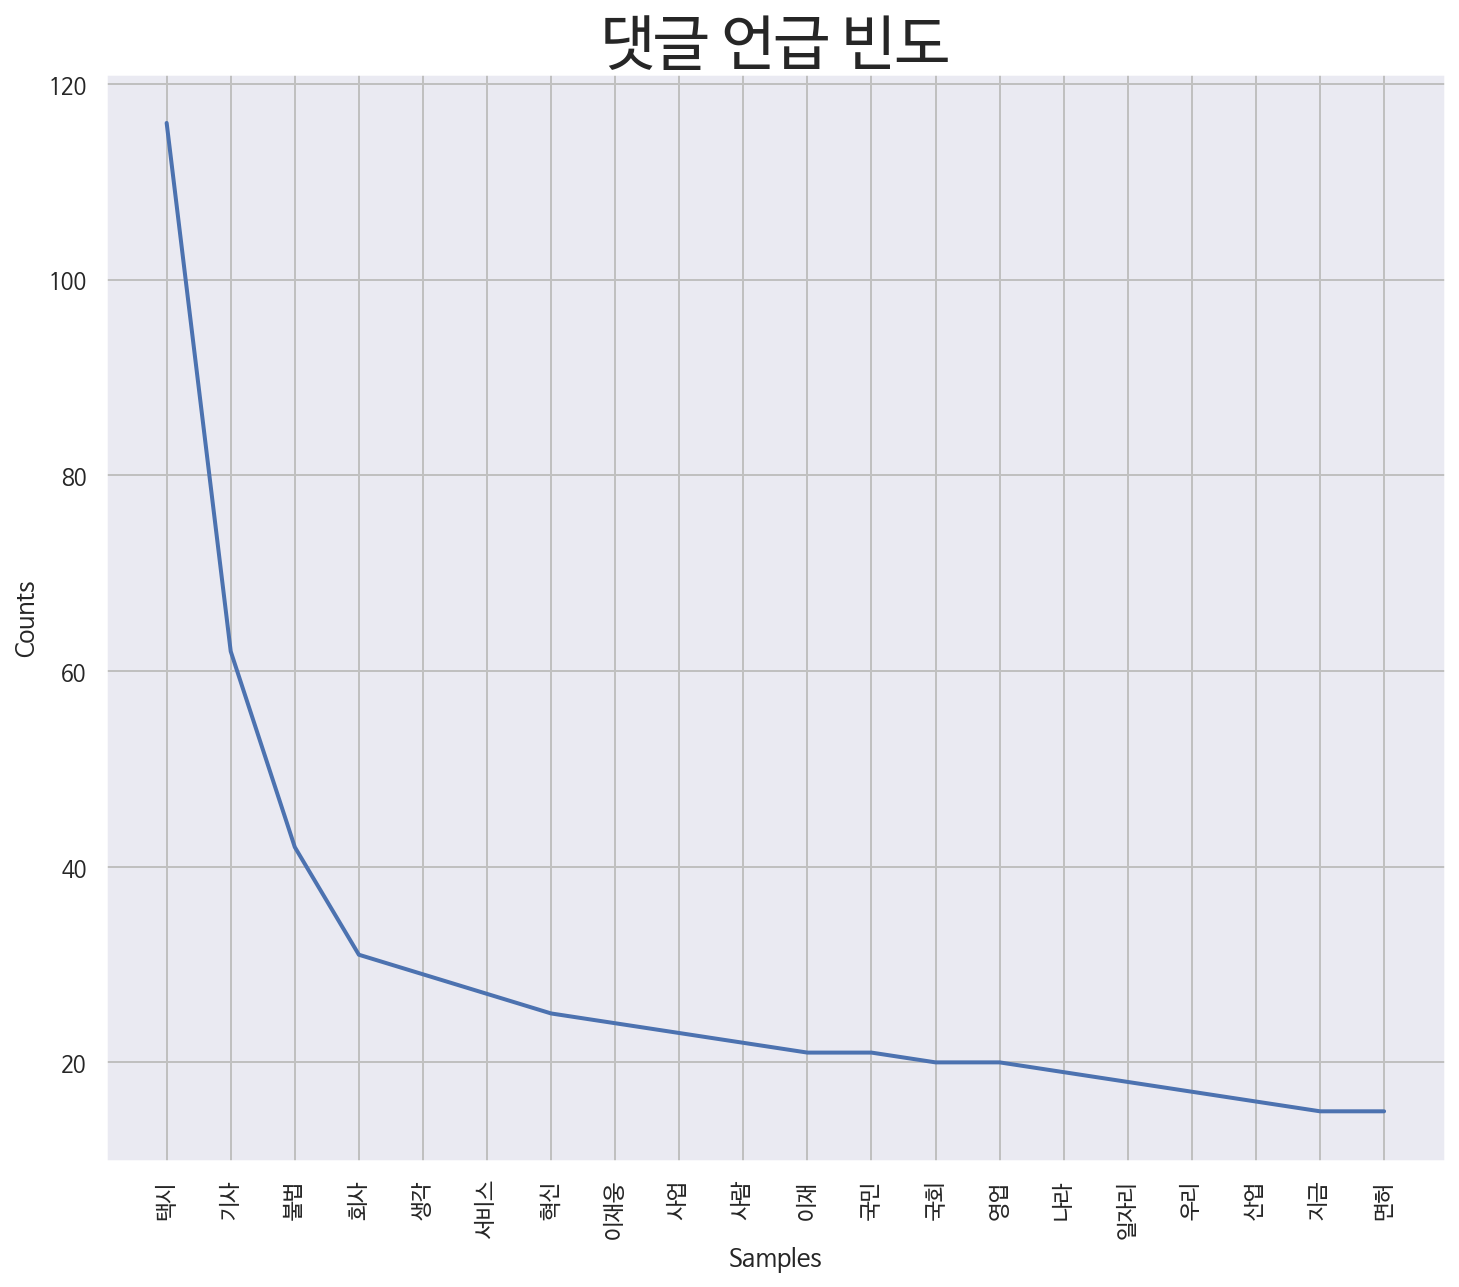

In [21]:
import nltk 
from nltk.probability import FreqDist 
import matplotlib as mpl

plt.figure(figsize=(12,10))
#plt.rc('xtick',labelsize=15)
#plt.rc('ytick',labelsize=15)
plt.xlabel("엑스축 라벨") # 변경이 안된다..?
plt.title("댓글 언급 빈도", fontsize=30, verticalalignment='baseline')

# 두 단어 이상의 글자만 선택한 데이터에서 빈도수 구하고 그려주기
graph_comm = FreqDist(rm_dupl) 
graph_comm.plot(20);

### 워드크라우드

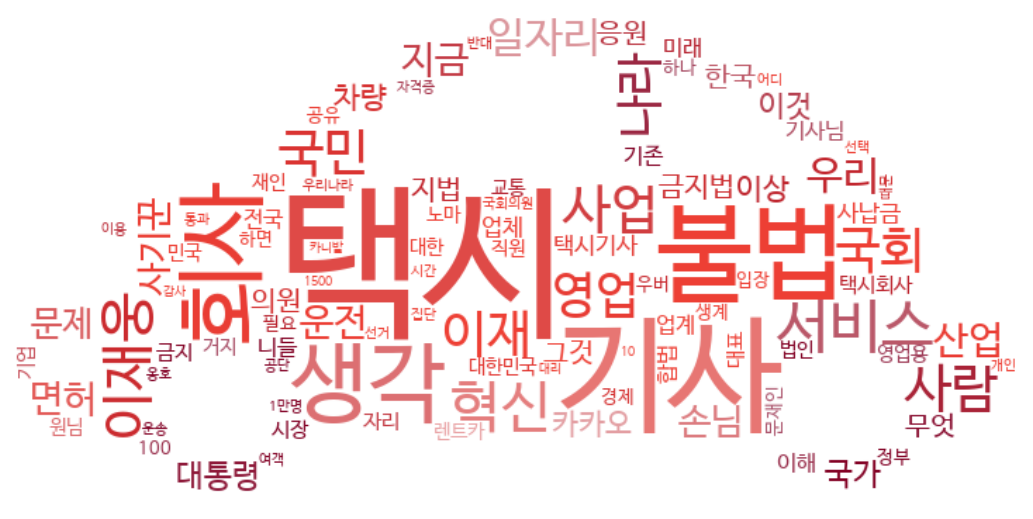

In [25]:
from os import path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()


alice_coloring = np.array(Image.open(path.join(d, './car.jpg')))
stopwords = set(STOPWORDS)
stopwords.add("said")

wc = WordCloud(font_path = fontpath, background_color='white',mask=alice_coloring,width=1500, height=1000)
wc.generate_from_frequencies(result_freq_mc_dict) 


image_colors = ImageColorGenerator(alice_coloring, default_color="hot")

plt.imshow(wc.recolor(color_func=image_colors), interpolation="bilinear")
figure = plt.gcf() 
figure.set_size_inches(9, 8)
plt.axis('off') 

# 파일 저장 코드
plt.savefig('word_cloud_korea.png',dpi=500)
plt.show()

### 네트워크 분석

- 불용어 처리
    - https://junior-developer.tistory.com/8
    - http://blog.naver.com/PostView.nhn?blogId=qbxlvnf11&logNo=221434157182&categoryNo=75&parentCategoryNo=0&viewDate=&currentPage=1&postListTopCurrentPage=1&from=postView
    - 한국어 처리 패키지 중 mecab을 쓰는게 나아보인다. 속도가 빠르다.
    - 타다를 명사로 골라주긴 하나 kkma에 비해 20건 정도 적음. 사용자 사전 추가 필요,
    - https://bitbucket.org/eunjeon/mecab-ko-dic/src/master/ 
    - 사용자 사전 추가 과정이 상당히 번거롭다.

In [26]:
# 불용어 작성을 위해 한단어만 선택하고 저장하기
# 두 단어 이상의 글자만 선택하기
rm_one = []
for i in duplicate_comment:
    if len(i) == 1:
        rm_one.append(i)
        
rm_one_stop = list(set(rm_one))

rm_one_stop.remove("차")  
"차" in rm_one_stop
#rm_one_stop

False

In [27]:
add_stop = ['는', 'ㅂ니다', '라', '해', '꽁', '대', '재', '해', '채', '재']

In [29]:
# stop word 사전 불러오기

with open("koreanStopwords.txt", 'r') as f:
    lines = f.readlines()

stopwords = []
for line in lines:
    line = line.replace('\n', '')
    stopwords.append(line)
f.close()

stopwords
stop_word_t = stopwords + rm_one_stop + add_stop #+ one_word
stop_word_t = list(set(stop_word_t))
stop_word_t[0:10]


['중', '점', '개\t', 'ㅜ', '피', '싢', '허', '놓', '잌', '간']

불용어 처리

In [30]:
# Data Preprocessing
def preprocessing(text):
    # tokenize into words
    hangul = re.compile('[^가-힣a-zA-Z\s]')
    text = hangul.sub('', str(text))
    tokens = kkma.nouns(text) # 명사로 처리.
    
    # remove stopwords
    stop = stop_word_t
    tokens = [token for token in tokens if token not in stop]
    
    preprocessed_text= ' '.join(tokens)
    return preprocessed_text

clean_text = []
i = 0
for data in comment_sample:
    preprocessed = preprocessing(data)
    clean_text.append(preprocessed)


In [31]:
clean_text[0:10]

['일자리 베이 베이직기사가 직기 사가 여명 숫자 누적 누적합계숫자 합계 차량 차량댓수 카니발 대당 평균 평균기사숫자 기사 명명 납득 과장 소수 인원수 실직 대안 서울 서울소재 소재 수십 수십개 택시 택시회사 회사 취업 택시기사자리 자리',
 '차 차산업 산업 공유 공유경제 경제 무엇 이재 이재웅 서비스 실천',
 '개택시 택시 기사 유권자',
 '시대 산업 도태 권력',
 '차량 기사 명이 차 대당 명한 명한달 주말 계산 생계 걱정 구라',
 '배심',
 '불법 범죄 범죄행이임 행이 기사 손가락 법인 법인택시 택시 회사 기사모집 모집 대리 대리기사 손가락빠노 빠노 인간',
 '한국형 우버 허용 정부 노후 저질 저질택시 택시 보호',
 '제웅 대표 대표사기꾼 사기꾼',
 '노무현 태광 태광실업 실업 박연차 연차 문제인은 인은 소카 이재 유착 유착관계 관계 조사']

In [32]:
# 연관성 분석을 위해 단어별 댓글 쪼개기
dataset = []
for i in range(len(clean_text)):
    dataset.append(kkma.nouns(re.sub('[^가-힣a-zA-Z\s]','',clean_text[i])))
    
test_asso = dataset
test_asso

[['일자리',
  '베이',
  '베이직기사',
  '직',
  '기사',
  '직기',
  '사가',
  '여명',
  '숫자',
  '누적',
  '누적합계숫자',
  '합계',
  '차량',
  '차량댓수',
  '댓',
  '수',
  '카니발',
  '대당',
  '평균',
  '평균기사숫자',
  '명명',
  '납득',
  '과장',
  '소수',
  '인원수',
  '실직',
  '대안',
  '서울',
  '서울소재',
  '소재',
  '수십',
  '수십개',
  '개',
  '택시',
  '택시회사',
  '회사',
  '취업',
  '택시기사자리',
  '자리'],
 ['차', '차산업', '산업', '공유', '공유경제', '경제', '무엇', '이재', '이재웅', '웅', '서비스', '실천'],
 ['개', '개택시', '택시', '기사', '유권자'],
 ['시대', '산업', '도태', '권력'],
 ['차량', '기사', '명이', '차', '대당', '명한', '명한달', '달', '주말', '계산', '생계', '걱정', '구라'],
 ['배심'],
 ['불법',
  '범죄',
  '범죄행이임',
  '행이',
  '임',
  '기사',
  '손가락',
  '법인',
  '법인택시',
  '택시',
  '회사',
  '기사모집',
  '모집',
  '대리',
  '대리기사',
  '손가락빠노',
  '빠노',
  '인간'],
 ['한국형', '우버', '허용', '정부', '노후', '저질', '저질택시', '택시', '보호'],
 ['제웅', '대표', '대표사기꾼', '사기꾼'],
 ['노무현',
  '태광',
  '태광실업',
  '실업',
  '박',
  '박연차',
  '연차',
  '문제',
  '문제인은',
  '인은',
  '소',
  '소카',
  '카',
  '이재',
  '유착',
  '유착관계',
  '관계',
  '조사'],
 ['김',
  '김경진무소속',
  '경진',
  '무소속',
  '무

In [33]:
# 연관성분석 명령어, 지지도가 0.01인 것만 가져오기
result = (list(apriori(test_asso, min_support = 0.019)))

In [34]:
#items가 2개인 것만 선택하기
df = pd.DataFrame(result)
df['length'] = df['items'].apply(lambda x: len(x))
df = df[(df['length'] ==2) ].sort_values(by='support',ascending=False)
df

,items,support,ordered_statistics,length
62,"(기사, 택시)",0.089888,"[((), (기사, 택시), 0.0898876404494382, 1.0), ((기사...",2
80,"(회사, 택시)",0.065169,"[((), (택시, 회사), 0.0651685393258427, 1.0), ((택시...",2
72,"(웅, 이재)",0.049438,"[((), (웅, 이재), 0.04943820224719101, 1.0), ((웅)...",2
73,"(웅, 이재웅)",0.047191,"[((), (웅, 이재웅), 0.04719101123595506, 1.0), ((웅...",2
74,"(이재웅, 이재)",0.047191,"[((), (이재웅, 이재), 0.04719101123595506, 1.0), ((...",2
64,"(기사, 회사)",0.033708,"[((), (기사, 회사), 0.033707865168539325, 1.0), ((...",2
76,"(차, 택시)",0.031461,"[((), (차, 택시), 0.03146067415730337, 1.0), ((차)...",2
70,"(영업, 택시)",0.031461,"[((), (영업, 택시), 0.03146067415730337, 1.0), ((영...",2
57,"(금지법, 지법)",0.029213,"[((), (금지법, 지법), 0.029213483146067417, 1.0), (...",2
63,"(기사, 택시기사)",0.029213,"[((), (기사, 택시기사), 0.029213483146067417, 1.0), ...",2


In [35]:
# 네트워크 그려주기
G = nx.Graph()
#G = nx.path_graph(4)
ar=(df['items']); 
G.add_edges_from(ar)
G.remove_edges_from([('해라', '라'), ('해라', '해'), ('라', '해'), (0, 1), (1, 2), (2, 3) ,('시', '채')])

In [36]:
G.edges()

EdgeView([('기사', '택시'), ('기사', '회사'), ('기사', '택시기사'), ('기사', '님'), ('기사', '기사님'), ('기사', '차'), ('기사', '운전'), ('택시', '회사'), ('택시', '차'), ('택시', '영업'), ('택시', '택시기사'), ('택시', '불법'), ('택시', '서비스'), ('택시', '택시회사'), ('택시', '일자리'), ('택시', '나라'), ('택시', '운전'), ('택시', '사납금'), ('택시', '혁신'), ('택시', '국민'), ('회사', '택시회사'), ('웅', '이재'), ('웅', '이재웅'), ('이재', '이재웅'), ('금지법', '지법'), ('님', '기사님')])

In [37]:
#pos = nx.planar_layout(G)
pr = nx.pagerank(G)
nsize = np.array([v for v in pr.values()])
nsize = 2000 * (nsize - min(nsize)) / (max(nsize) - min(nsize))

In [38]:
#pos = nx.random_layout(G)
#pos = nx.bipartite_layout(G)
#pos = nx.circular_layout(G)
#pos = nx.kamada_kawai_layout(G)
#pos = nx.planar_layout(G)
#pos = nx.rescale_layout(G)
#pos = nx.shell_layout(G)
#pos = nx.spring_layout(G)
#pos = nx.spectral_layout(G)
#pos = nx.spiral_layout(G)

- 지지도 0.01

In [39]:
result = (list(apriori(test_asso, min_support = 0.01)))
df = pd.DataFrame(result)
df['length'] = df['items'].apply(lambda x: len(x))
df = df[(df['length'] ==2) ].sort_values(by='support',ascending=False)

G = nx.Graph()
#G = nx.path_graph(4)
ar=(df['items']); 
G.add_edges_from(ar)
G.remove_edges_from([('해라', '라'), ('해라', '해'), ('라', '해'), (0, 1), (1, 2), (2, 3) ,('시', '채')])
pr = nx.pagerank(G)
nsize = np.array([v for v in pr.values()])
nsize = 2000 * (nsize - min(nsize)) / (max(nsize) - min(nsize))
pos = nx.kamada_kawai_layout(G)

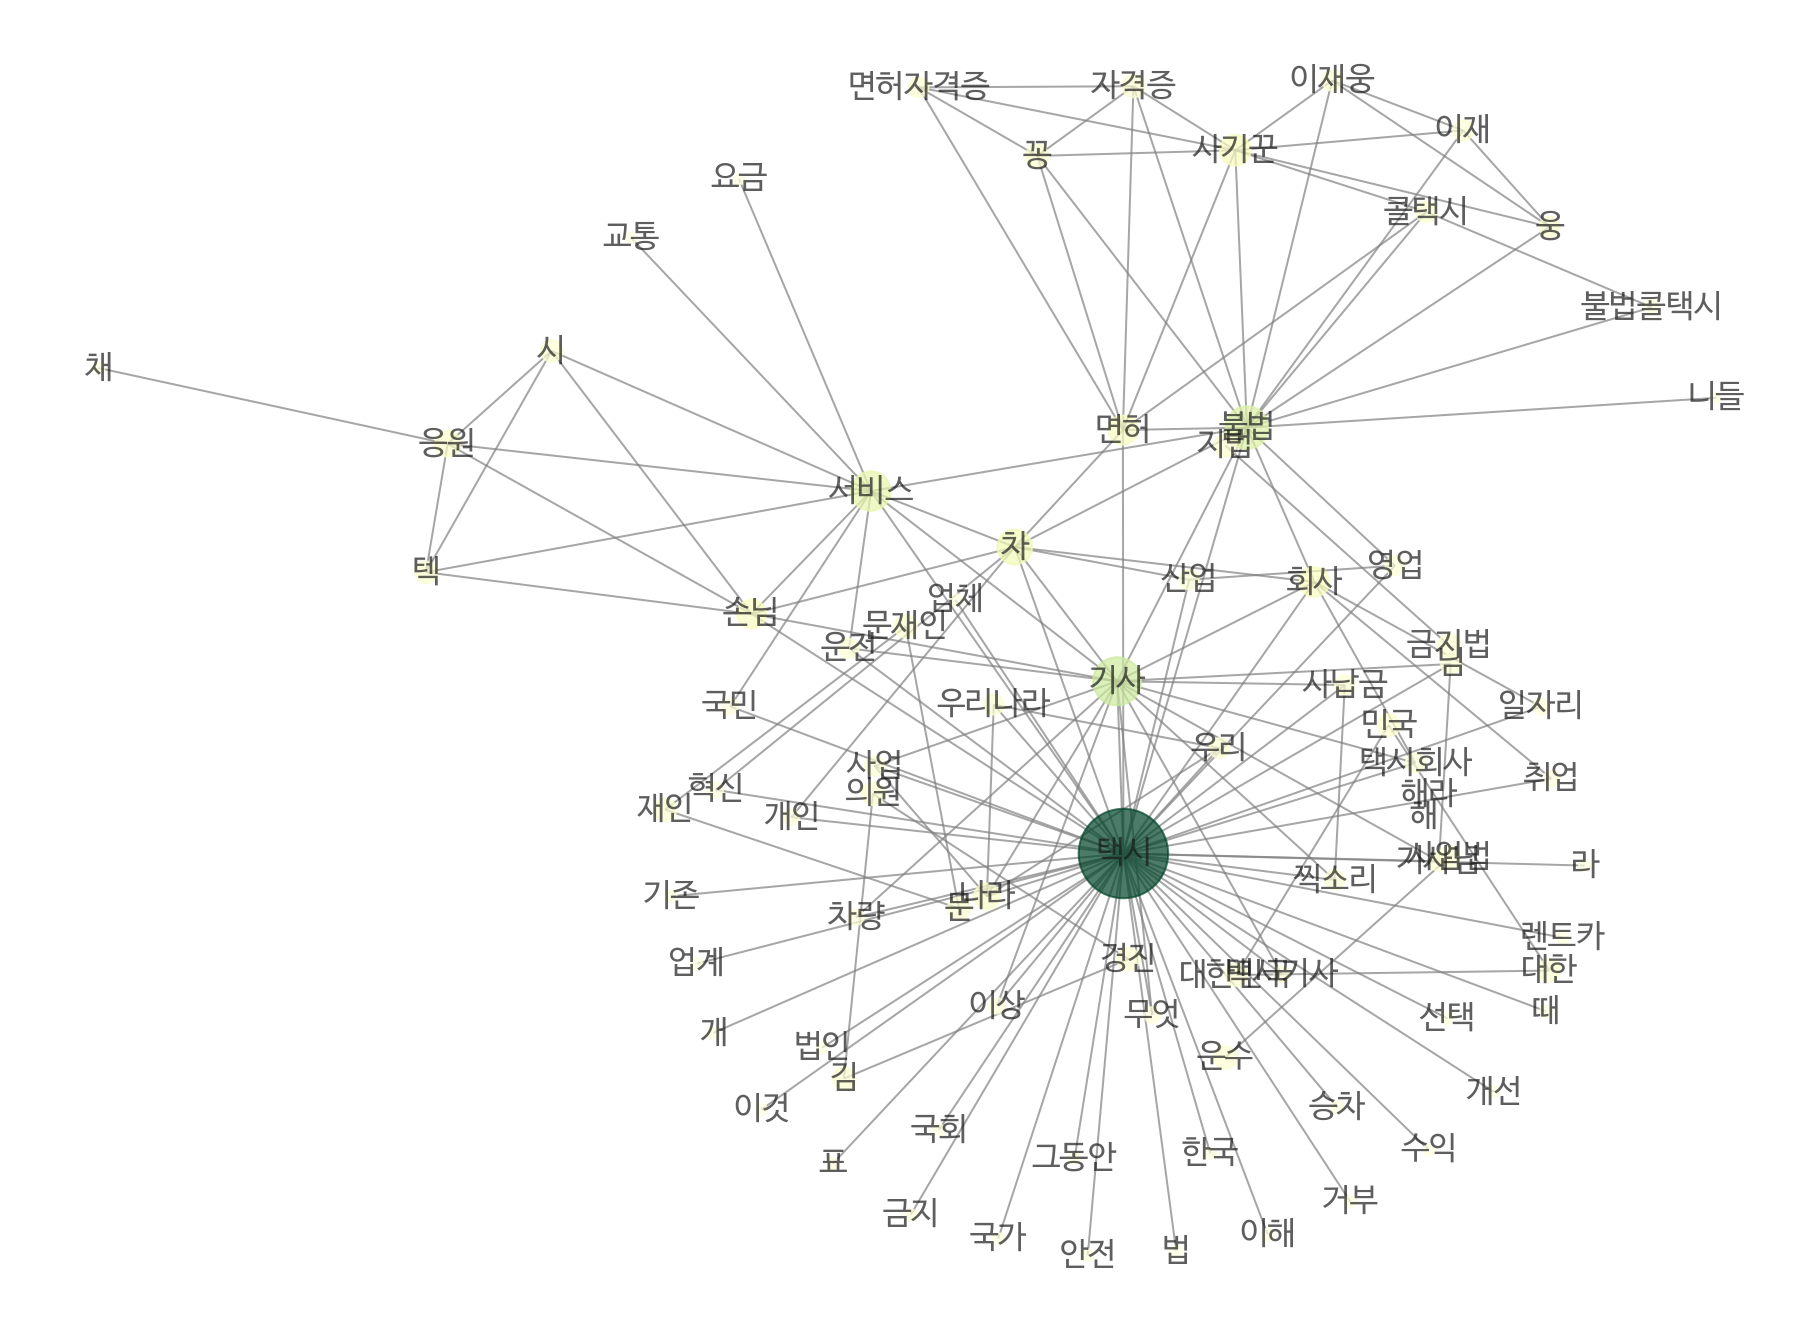

In [41]:
plt.figure(figsize=(16,12))
plt.axis('off')
nx.draw_networkx(G, font_family='NanumBarunGothic', font_size=16,
                pos=pos, node_color=list(pr.values()), node_size=nsize,
                alpha = 0.7, edge_color='.5', cmap=plt.cm.YlGn)

- 지지도 0.14

In [42]:
result = (list(apriori(test_asso, min_support = 0.014)))
df = pd.DataFrame(result)
df['length'] = df['items'].apply(lambda x: len(x))
df = df[(df['length'] ==2) ].sort_values(by='support',ascending=False)

G = nx.Graph()
#G = nx.path_graph(4)
ar=(df['items']); 
G.add_edges_from(ar)
G.remove_edges_from([('해라', '라'), ('해라', '해'), ('라', '해'), (0, 1), (1, 2), (2, 3) ,('시', '채')])
pr = nx.pagerank(G)
nsize = np.array([v for v in pr.values()])
nsize = 2000 * (nsize - min(nsize)) / (max(nsize) - min(nsize))
pos = nx.kamada_kawai_layout(G)

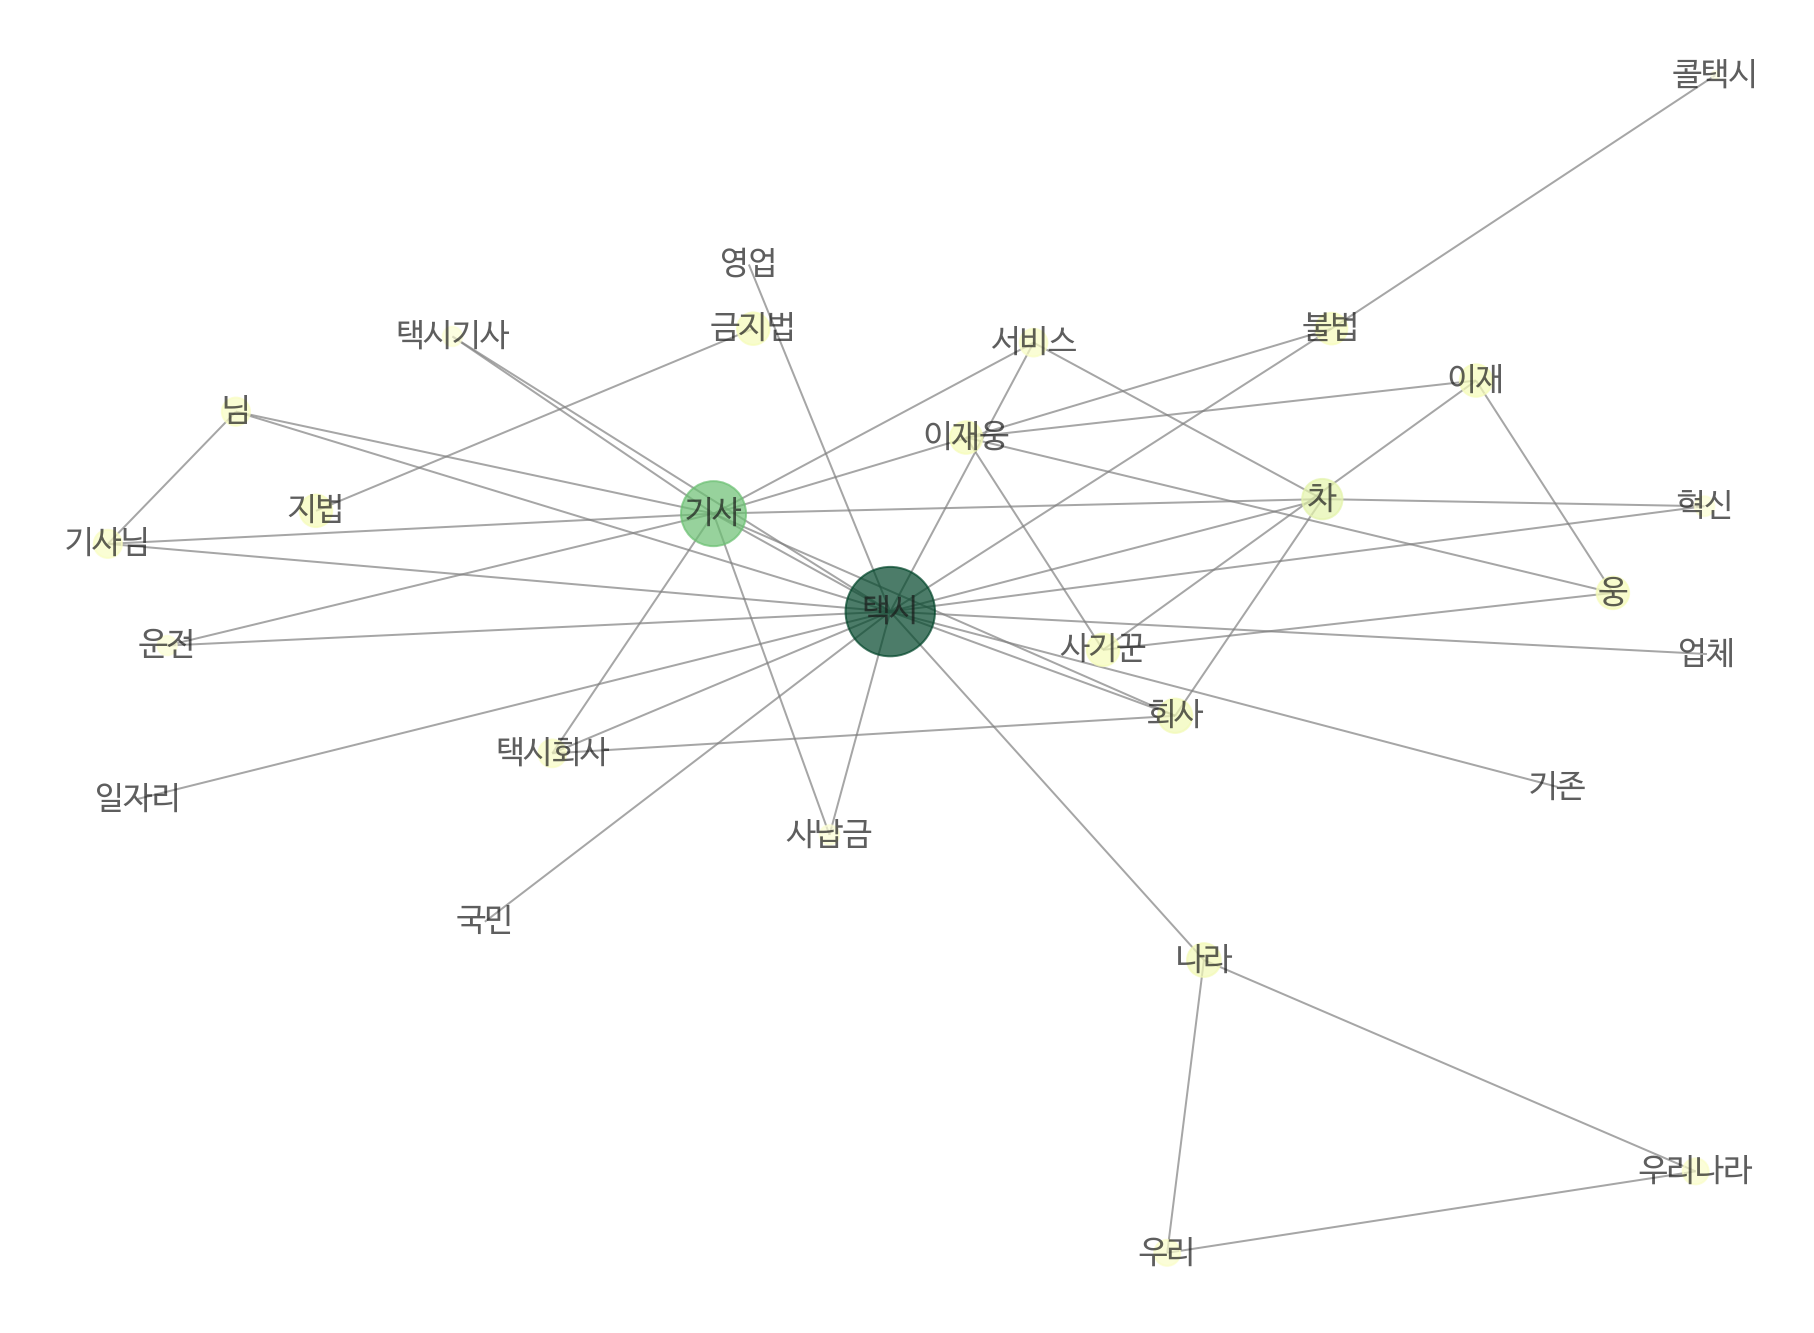

In [43]:
plt.figure(figsize=(16,12))
plt.axis('off')
nx.draw_networkx(G, font_family='NanumBarunGothic', font_size=16,
                pos=pos, node_color=list(pr.values()), node_size=nsize,
                alpha = 0.7, edge_color='.5', cmap=plt.cm.YlGn)

- 지지도 0.18

In [44]:
result = (list(apriori(test_asso, min_support = 0.018)))
df = pd.DataFrame(result)
df['length'] = df['items'].apply(lambda x: len(x))
df = df[(df['length'] ==2) ].sort_values(by='support',ascending=False)

G = nx.Graph()
#G = nx.path_graph(4)
ar=(df['items']); 
G.add_edges_from(ar)
G.remove_edges_from([('해라', '라'), ('해라', '해'), ('라', '해'), (0, 1), (1, 2), (2, 3) ,('시', '채')])
pr = nx.pagerank(G)
nsize = np.array([v for v in pr.values()])
nsize = 2000 * (nsize - min(nsize)) / (max(nsize) - min(nsize))
pos = nx.kamada_kawai_layout(G)

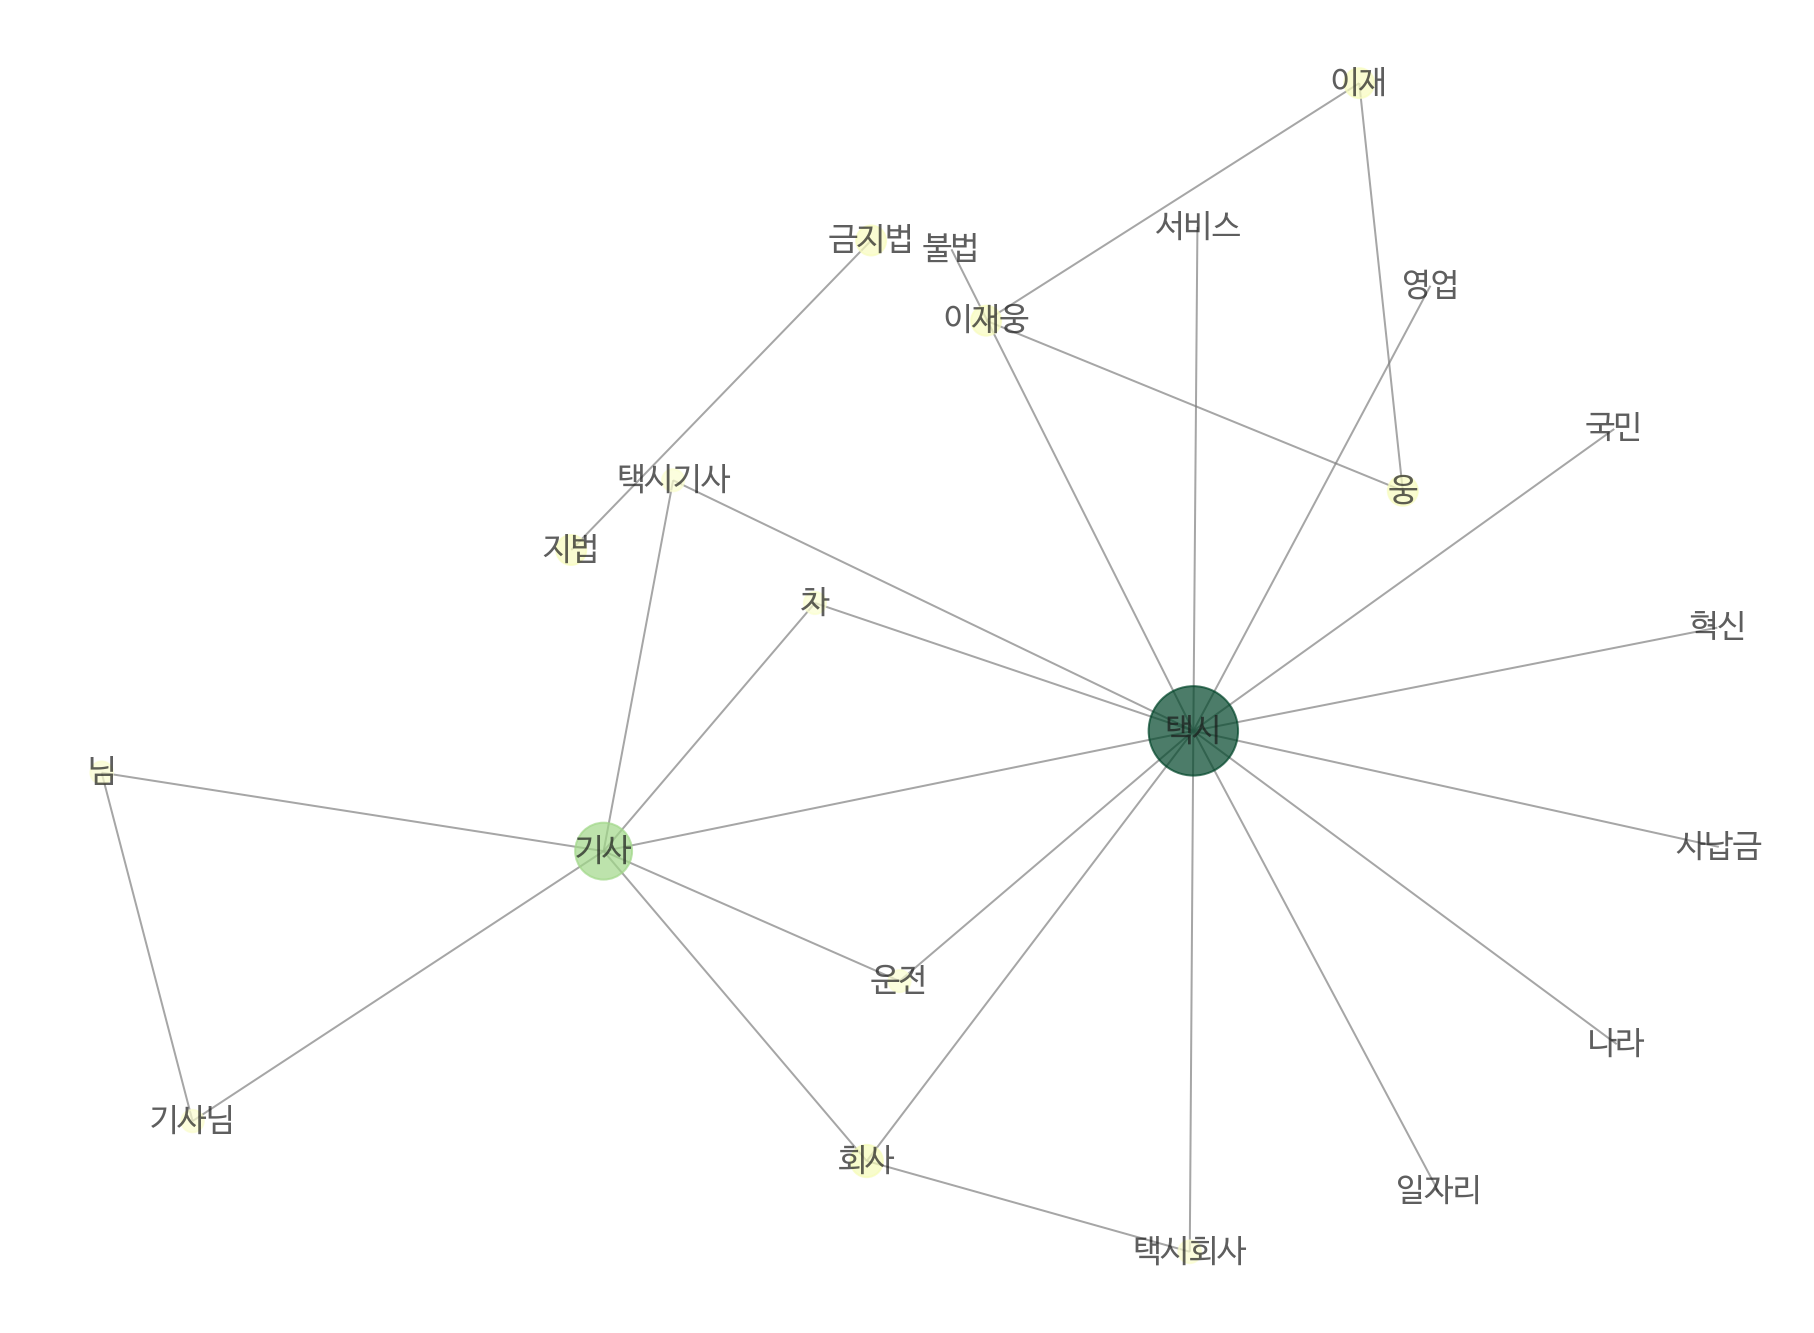

In [45]:
plt.figure(figsize=(16,12))
plt.axis('off')
nx.draw_networkx(G, font_family='NanumBarunGothic', font_size=16,
                pos=pos, node_color=list(pr.values()), node_size=nsize,
                alpha = 0.7, edge_color='.5', cmap=plt.cm.YlGn)

- 지지도 0.19

In [46]:
result = (list(apriori(test_asso, min_support = 0.019)))
df = pd.DataFrame(result)
df['length'] = df['items'].apply(lambda x: len(x))
df = df[(df['length'] ==2) ].sort_values(by='support',ascending=False)

G = nx.Graph()
#G = nx.path_graph(4)
ar=(df['items']); 
G.add_edges_from(ar)
G.remove_edges_from([('해라', '라'), ('해라', '해'), ('라', '해'), (0, 1), (1, 2), (2, 3) ,('시', '채')])
pr = nx.pagerank(G)
nsize = np.array([v for v in pr.values()])
nsize = 2000 * (nsize - min(nsize)) / (max(nsize) - min(nsize))
pos = nx.kamada_kawai_layout(G)

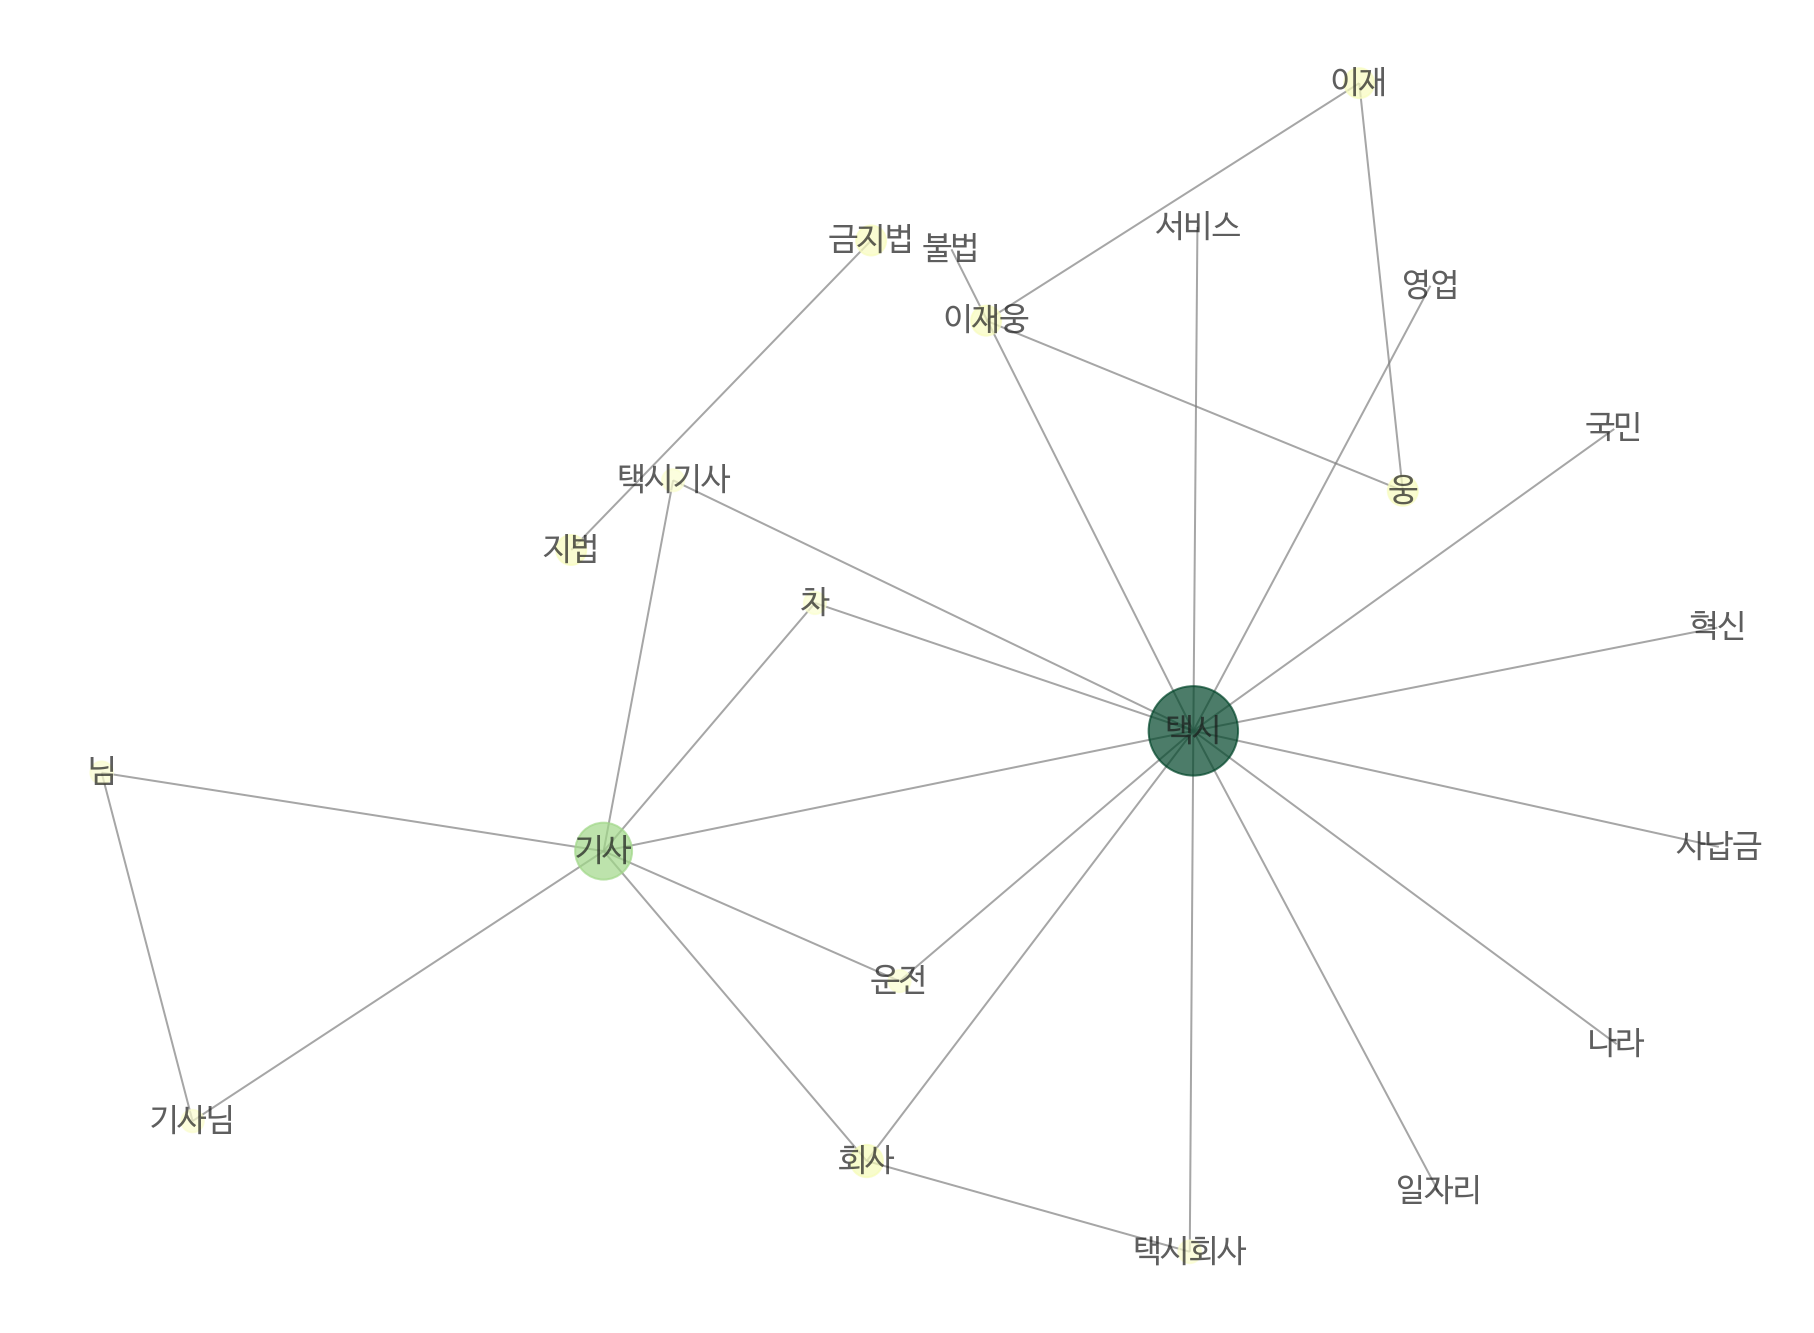

In [47]:
plt.figure(figsize=(16,12))
plt.axis('off')
nx.draw_networkx(G, font_family='NanumBarunGothic', font_size=16,
                pos=pos, node_color=list(pr.values()), node_size=nsize,
                alpha = 0.7, edge_color='.5', cmap=plt.cm.YlGn)

- 지지도 0.02

In [48]:
result = (list(apriori(test_asso, min_support = 0.02)))
df = pd.DataFrame(result)
df['length'] = df['items'].apply(lambda x: len(x))
df = df[(df['length'] ==2) ].sort_values(by='support',ascending=False)

G = nx.Graph()
#G = nx.path_graph(4)
ar=(df['items']); 
G.add_edges_from(ar)
G.remove_edges_from([('해라', '라'), ('해라', '해'), ('라', '해'), (0, 1), (1, 2), (2, 3) ,('시', '채')])
pr = nx.pagerank(G)
nsize = np.array([v for v in pr.values()])
nsize = 2000 * (nsize - min(nsize)) / (max(nsize) - min(nsize))


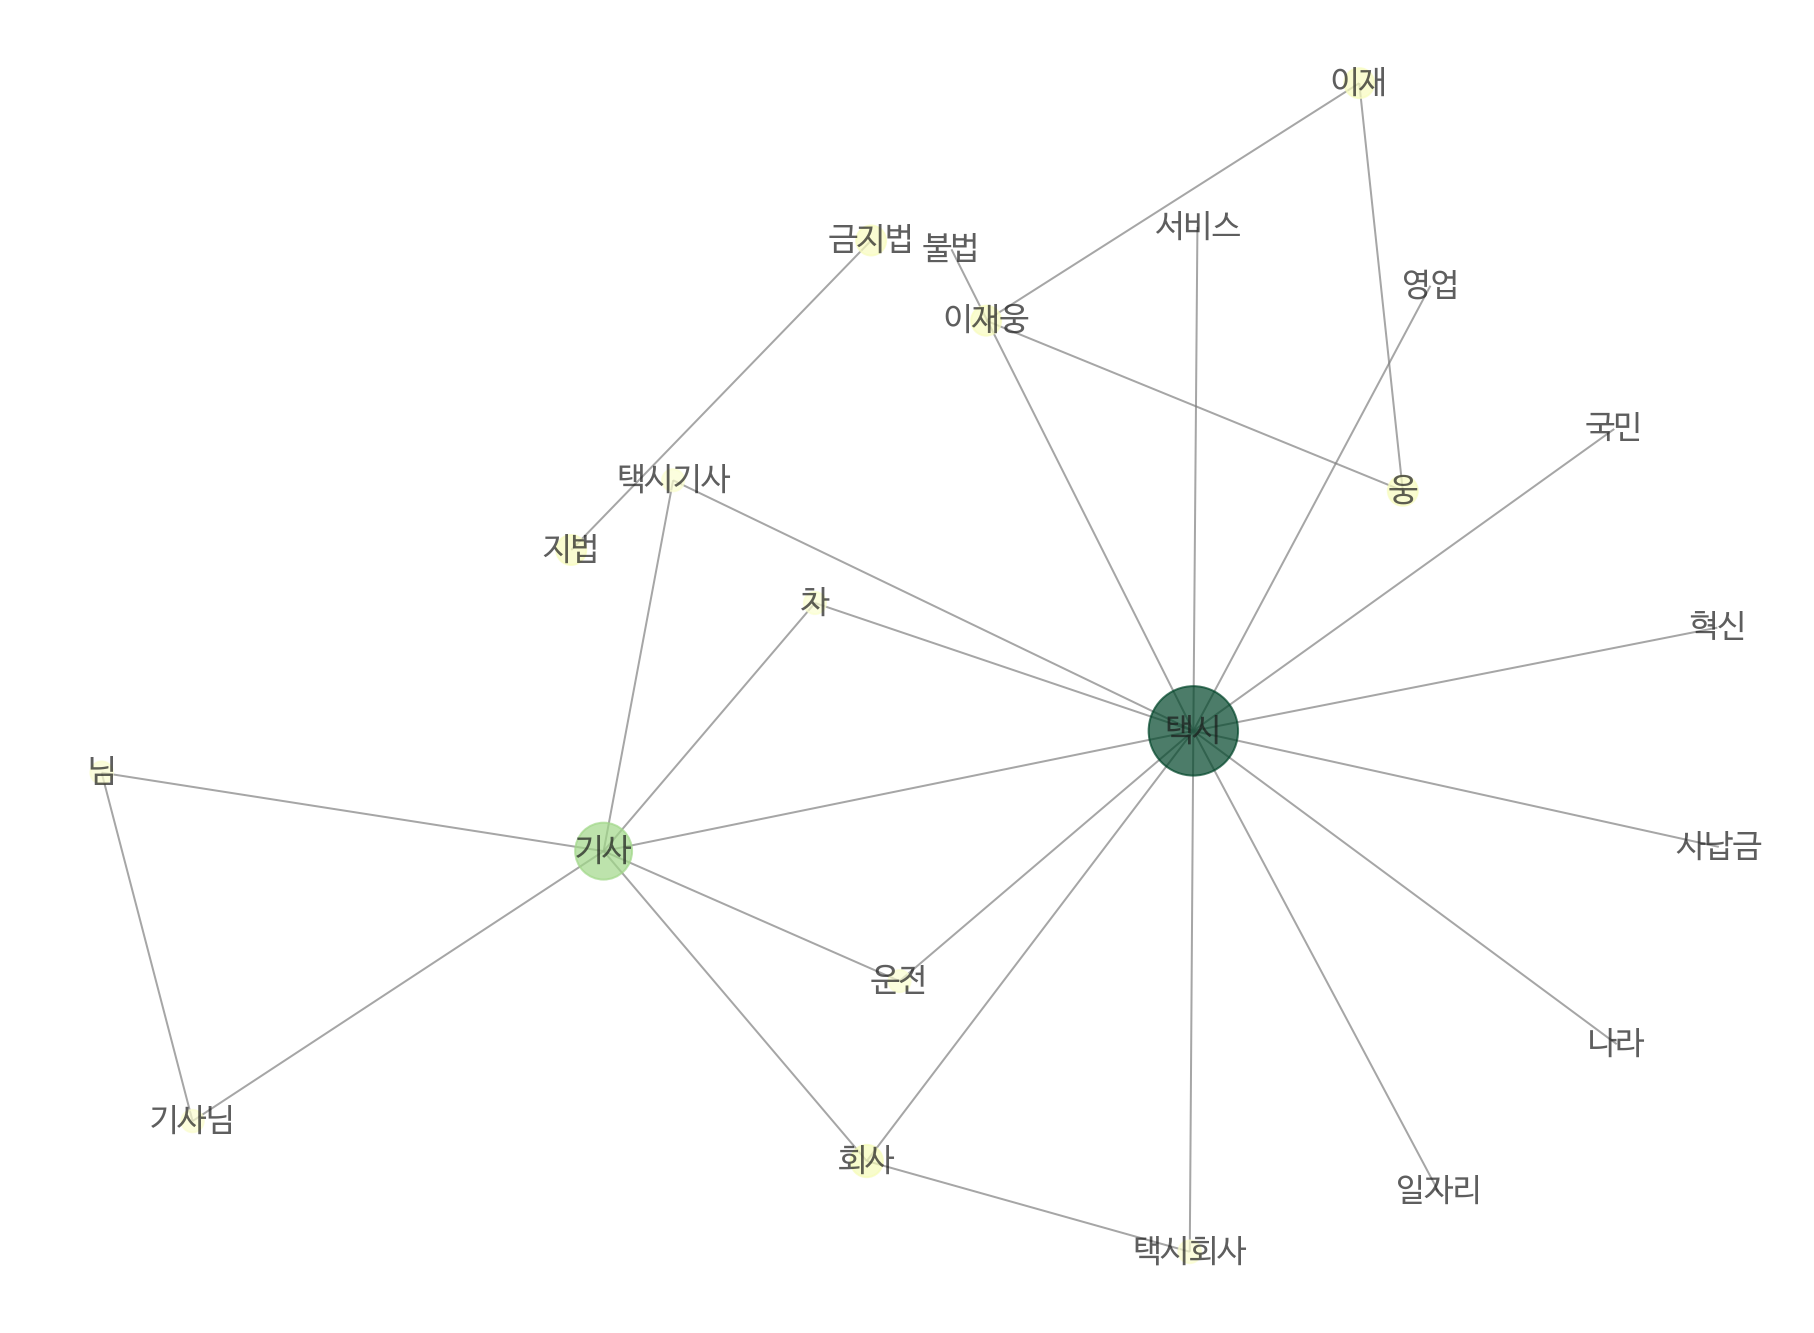

In [49]:
plt.figure(figsize=(16,12))
plt.axis('off')
nx.draw_networkx(G, font_family='NanumBarunGothic', font_size=16,
                pos=pos, node_color=list(pr.values()), node_size=nsize,
                alpha = 0.7, edge_color='.5', cmap=plt.cm.YlGn)